Tutorial CV 1

Meilany Dinda Talitha

23/517897/PA/22220

# Import Library

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

#Load Dataset

In [2]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1P8mpSR8UgC3FKE5zD5n6JIdKkuNVHfra' -O dataset.zip

--2025-04-27 02:18:14--  https://docs.google.com/uc?export=download&id=1P8mpSR8UgC3FKE5zD5n6JIdKkuNVHfra
Resolving docs.google.com (docs.google.com)... 142.250.107.139, 142.250.107.113, 142.250.107.102, ...
Connecting to docs.google.com (docs.google.com)|142.250.107.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1P8mpSR8UgC3FKE5zD5n6JIdKkuNVHfra&export=download [following]
--2025-04-27 02:18:15--  https://drive.usercontent.google.com/download?id=1P8mpSR8UgC3FKE5zD5n6JIdKkuNVHfra&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.142.132, 2607:f8b0:400e:c09::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.142.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 342044 (334K) [application/octet-stream]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>] 334.03K  --.-KB/s    i

In [3]:
!unzip dataset.zip

Archive:  dataset.zip
   creating: images/George_W_Bush/
  inflating: images/George_W_Bush/1.jpg  
  inflating: images/George_W_Bush/10.jpg  
  inflating: images/George_W_Bush/2.jpg  
  inflating: images/George_W_Bush/3.jpg  
  inflating: images/George_W_Bush/4.jpg  
  inflating: images/George_W_Bush/5.jpg  
  inflating: images/George_W_Bush/6.jpg  
  inflating: images/George_W_Bush/7.jpg  
  inflating: images/George_W_Bush/8.jpg  
  inflating: images/George_W_Bush/9.jpg  
   creating: images/Laura_Bush/
  inflating: images/Laura_Bush/1.jpg  
  inflating: images/Laura_Bush/10.jpg  
  inflating: images/Laura_Bush/2.jpg  
  inflating: images/Laura_Bush/3.jpg  
  inflating: images/Laura_Bush/4.jpg  
  inflating: images/Laura_Bush/5.jpg  
  inflating: images/Laura_Bush/6.jpg  
  inflating: images/Laura_Bush/7.jpg  
  inflating: images/Laura_Bush/8.jpg  
  inflating: images/Laura_Bush/9.jpg  
   creating: images/Serena_Williams/
  inflating: images/Serena_Williams/1.jpg  
  inflating: image

In [4]:
def load_image(image_path):
    """
    Membaca gambar dari path dan mengonversinya menjadi grayscale.

    Args:
        image_path (str): Path file gambar.

    Returns:
        tuple: (gambar warna, gambar grayscale)
    """
    image = cv2.imread(image_path)
    if image is None:
      print('Error: Could not load image.')
      return None, None
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image, gray

In [7]:
dataset_dir = '/content/images'
images = []
labels = []
for root, dirs, files in os.walk(dataset_dir):
  if len(files) == 0:
    continue
  for f in files:
    _, image = load_image(os.path.join(root, f))
    if image is None:
      continue
    images.append(image)
    labels.append(root.split('/')[-1])

In [8]:
len(labels)

70

#Face Detection

In [9]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [10]:
def detect_faces(image_gray, scale_factor=1.1, min_neighbors=5, min_size=(30, 30)):
    """
    Mendeteksi wajah pada gambar grayscale menggunakan Haar Cascade.

    Args:
        image_gray (numpy.ndarray): Gambar dalam format grayscale.
        scale_factor (float): Parameter untuk memperkecil gambar saat pencarian wajah.
        min_neighbors (int): Jumlah minimum neighbor untuk validasi wajah.
        min_size (tuple): Ukuran minimum wajah yang akan dideteksi.

    Returns:
        list: List bounding box wajah yang terdeteksi.
    """
    faces = face_cascade.detectMultiScale(
      image_gray,
      scaleFactor=scale_factor,
      minNeighbors=min_neighbors,
      minSize=min_size
    )
    return faces

In [12]:
def crop_faces(image_gray, faces, return_all=False):
    """
    Memotong wajah dari gambar berdasarkan hasil deteksi wajah.

    Args:
        image_gray (numpy.ndarray): Gambar grayscale.
        faces (list): List koordinat wajah (x, y, w, h).
        return_all (bool): Jika True, potong semua wajah; jika False, hanya wajah terbesar.

    Returns:
        tuple: (list wajah terpotong, list bounding box wajah yang dipilih)
    """
    cropped_faces = []
    selected_faces = []
    if len(faces) > 0:
      if return_all:
        for x, y, w, h in faces:
          selected_faces.append((x, y, w, h))
          cropped_faces.append(image_gray[y:y+h, x:x+w])
      else:
        x, y, w, h = max(faces, key=lambda rect: rect[2] * rect[3])
        selected_faces.append((x, y, w, h))
        cropped_faces.append(image_gray[y:y+h, x:x+w])
    return cropped_faces, selected_faces

#Face Recognition

In [15]:
face_size = (128, 128)

def resize_and_flatten(face):
    """
    Resize wajah ke ukuran standar dan flatten menjadi 1D array.

    Args:
        face (numpy.ndarray): Gambar wajah.

    Returns:
        numpy.ndarray: Wajah yang telah di-flatten.
    """
    face_resized = cv2.resize(face, face_size)
    face_flattened = face_resized.flatten()
    return face_flattened

In [16]:
X = []
y = []

for image, label in zip(images, labels):
  faces = detect_faces(image)
  cropped_faces, _ = crop_faces(image, faces)
  if len(cropped_faces) > 0:
    face_flattened = resize_and_flatten(cropped_faces[0])
    X.append(face_flattened)
    y.append(label)

X = np.array(X)
y = np.array(y)

#numpy diolah kode C makanya lebih cepat

In [17]:
len(X)

70

In [18]:
len(y)

70

In [19]:
X.shape

(70, 16384)

In [20]:
#split dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=177, stratify=y)

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin

class MeanCentering(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    self.mean_face = np.mean(X, axis=0)
    return self
  def transform(self, X):
    return X - self.mean_face

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA

# membuat pipeline
pipe = Pipeline([
  ('centering', MeanCentering()),
  ('pca', PCA(svd_solver='randomized', whiten=True, random_state=177)),
  ('svc', SVC(kernel='linear', random_state=177))
])

In [23]:
from sklearn.metrics import classification_report

# training pipeline
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

   Abdullah_Gul       1.00      1.00      1.00         3
   Alvaro_Uribe       1.00      0.67      0.80         3
  George_W_Bush       0.50      0.67      0.57         3
     Laura_Bush       0.75      1.00      0.86         3
  Meilany_Dinda       1.00      1.00      1.00         3
Serena_Williams       0.67      0.67      0.67         3
 Vladimir_Putin       0.50      0.33      0.40         3

       accuracy                           0.76        21
      macro avg       0.77      0.76      0.76        21
   weighted avg       0.77      0.76      0.76        21



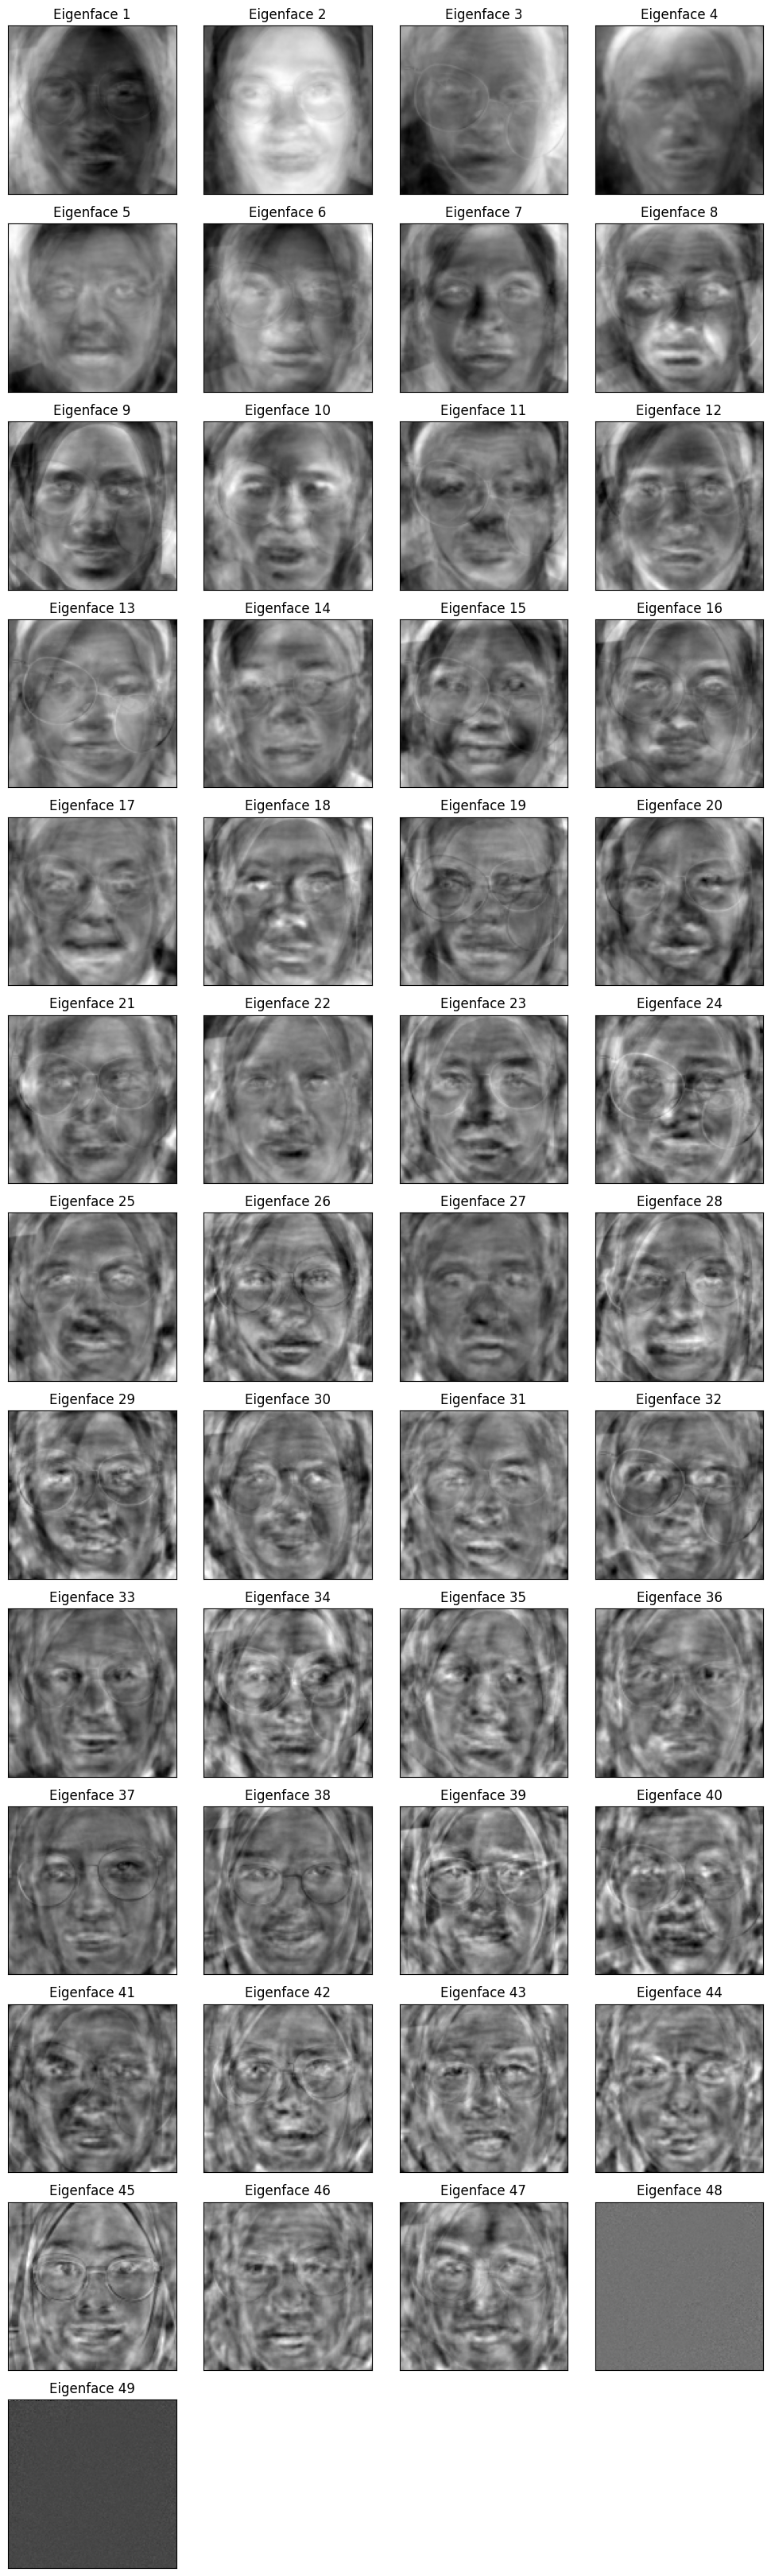

In [24]:
n_components = len(pipe[1].components_)

ncol = 4
nrow = (n_components + ncol - 1) // ncol
fig, axes = plt.subplots(nrow, ncol, figsize=(10, 2.5*nrow),
subplot_kw={'xticks':[], 'yticks':[]})

eigenfaces = pipe[1].components_.reshape((n_components,
X_train.shape[1]))
for i, ax in enumerate(axes.flat):
  # Check if i is within the bounds of eigenfaces
  if i < n_components:
    ax.imshow(eigenfaces[i].reshape(face_size), cmap='gray')
    ax.set_title(f'Eigenface {i+1}')
  else:
    # Hide any extra subplots if there are more subplots than eigenfaces
    ax.set_visible(False)
  plt.tight_layout()

plt.show()

In [25]:
# save model
import pickle
with open('eigenface_pipeline.pkl', 'wb') as f:
  pickle.dump(pipe, f)

In [26]:
def get_eigenface_score(X):
    """
    Menghitung confidence score dari hasil prediksi menggunakan decision function dari SVM.
    """
    X_pca = pipe[:2].transform(X) # Transformasi hingga PCA
    eigenface_scores = np.max(pipe[2].decision_function(X_pca), axis=1) # Ambil nilai skor prediksi tertinggi
    return eigenface_scores

In [27]:
def eigenface_prediction(image_gray):
    """
    Mendeteksi wajah pada gambar grayscale, lalu memprediksi identitasnya
    menggunakan model eigenface pipeline.

    Args:
        image_gray (np.ndarray): Gambar dalam format grayscale.

    Returns:
        tuple or str:
            - Jika wajah terdeteksi:
                (scores, labels, selected_faces)
                - scores (np.ndarray): Skor confidence untuk tiap prediksi.
                - labels (np.ndarray): Label (nama) hasil prediksi.
                - selected_faces (list of tuples): Koordinat (x, y, w, h) wajah.
            - Jika tidak ada wajah:
                'No face detected.'
    """
    faces = detect_faces(image_gray)
    cropped_faces, selected_faces = crop_faces(image_gray, faces)
    if len(cropped_faces) == 0:
      return 'No face detected.'
    X_face = []
    for face in cropped_faces:
      face_flattened = resize_and_flatten(face)
      X_face.append(face_flattened)

    X_face = np.array(X_face)
    labels = pipe.predict(X_face)
    scores = get_eigenface_score(X_face)

    return scores, labels, selected_faces

In [32]:
def draw_text(image, label, score, font=cv2.FONT_HERSHEY_SIMPLEX, pos=(0, 0), font_scale=0.6, font_thickness=2, text_color=(0, 0, 0), text_color_bg=(0, 255, 0)):
    """
    Menulis label dan skor di atas bounding box wajah.
    """
    x, y = pos
    score_text = f'Score: {score:.2f}'
    (w1, h1), _ = cv2.getTextSize(score_text, font, font_scale, font_thickness)
    (w2, h2), _ = cv2.getTextSize(label, font, font_scale, font_thickness)
    cv2.rectangle(image, (x, y-h1-h2-25), (x + max(w1, w2)+20, y), text_color_bg, -1)
    cv2.putText(image, label, (x+10, y-10), font, font_scale, text_color, font_thickness)
    cv2.putText(image, score_text, (x+10, y-h2-15), font, font_scale, text_color, font_thickness)

In [33]:
def draw_result(image, scores, labels, coords):
    """
    Menggambar hasil prediksi ke atas gambar asli: kotak wajah, nama label, dan skor.

    Args:
        image (np.ndarray): Gambar asli (BGR).
        scores (np.ndarray): Skor confidence untuk tiap prediksi.
        labels (np.ndarray): Label (nama) hasil prediksi.
        coords (list of tuples): Koordinat (x, y, w, h) untuk tiap wajah.

    Returns:
        np.ndarray: Gambar hasil dengan kotak, nama, dan skor ditambahkan.
    """
    result_image = image.copy()
    for (x, y, w, h), label, score in zip(coords, labels, scores):
      cv2.rectangle(result_image, (x, y), (x + w, y + h), (0, 255, 0),2)
      draw_text(result_image, label, score, pos=(x, y))
    return result_image

# Contoh Sample

In [5]:
sample_image, sample_image_gray = load_image('/content/images/George_W_Bush/1.jpg')

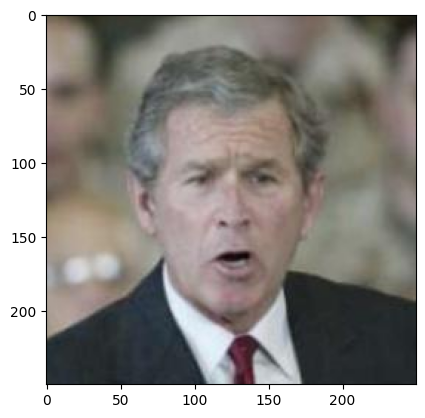

In [6]:
sample_image_rgb = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
plt.imshow(sample_image_rgb)

In [11]:
sample_faces = detect_faces(sample_image_gray, min_size=(50, 50))

#hasil deteksi = [x, y, w, h]

In [13]:
cropped_faces, _ = crop_faces(sample_image_gray, sample_faces)

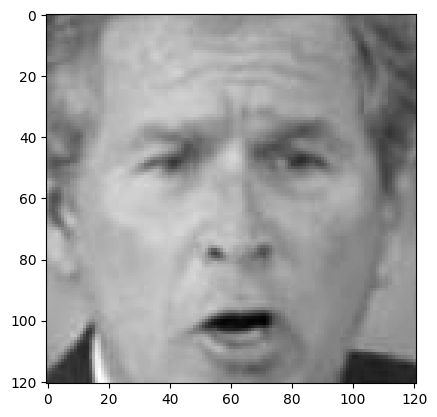

In [14]:
plt.imshow(cropped_faces[0], cmap = 'gray')

In [28]:
sample_scores, sample_labels, sample_faces = eigenface_prediction(sample_image_gray)

In [29]:
sample_scores

array([6.28571429])

In [30]:
sample_labels

array(['George_W_Bush'], dtype='<U15')

In [31]:
sample_faces

[(np.int32(64), np.int32(63), np.int32(121), np.int32(121))]

In [34]:
result_image = draw_result(sample_image, sample_scores, sample_labels, sample_faces)

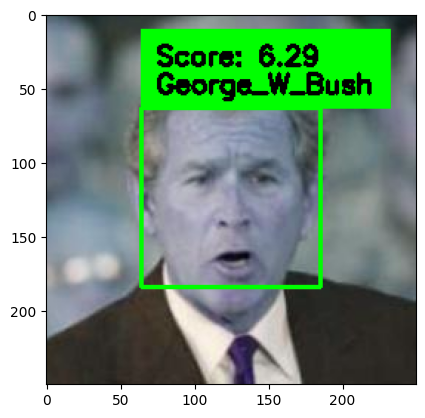

In [35]:
plt.imshow(result_image)

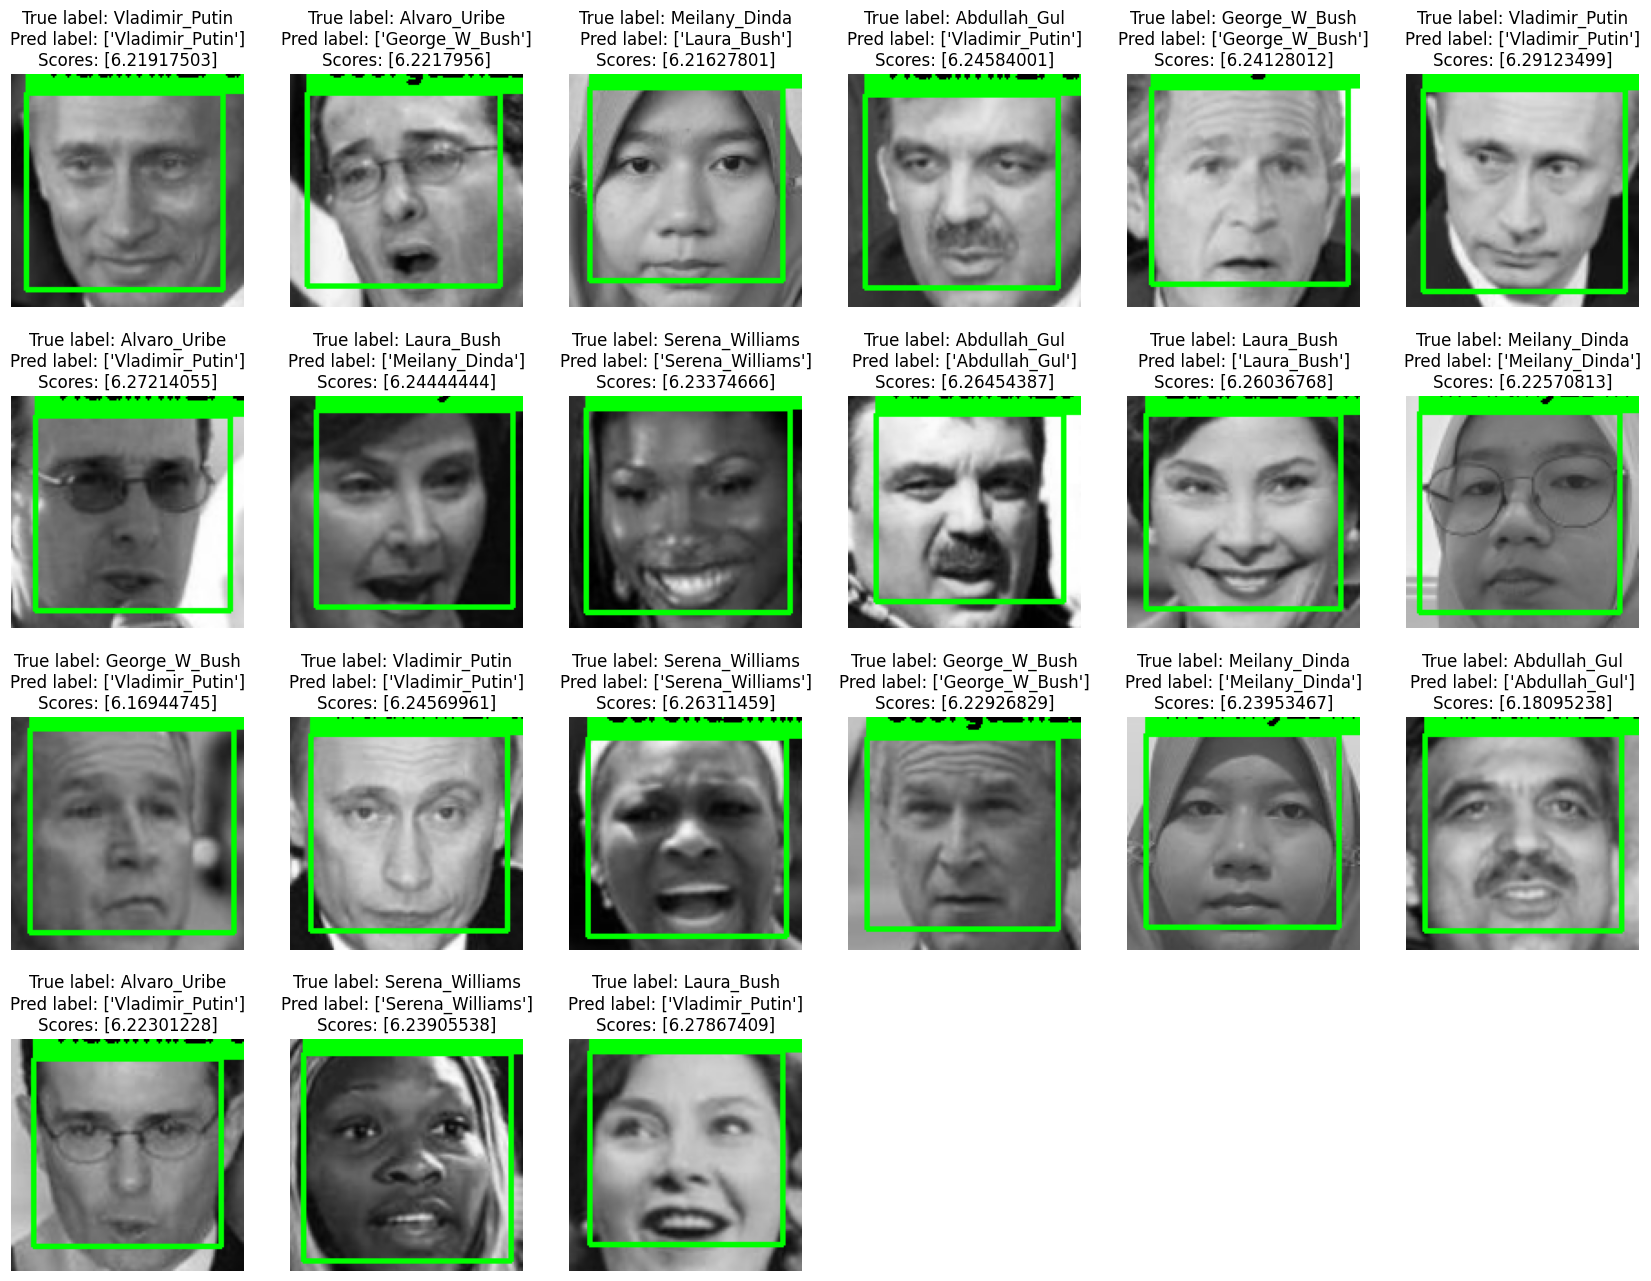

In [45]:
plt.figure(figsize=(len(X_test), 16))
for i in range(len(X_test)):
    img_gray = X_test[i].reshape(face_size)
    img = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB)
    sample_scores, sample_labels, sample_faces = eigenface_prediction(img_gray)
    result_image = draw_result(img, sample_scores, sample_labels, sample_faces)

    plt.subplot(4, 6, i + 1)
    plt.imshow(result_image)
    plt.title(f"True label: {y_test[i]}\nPred label: {sample_labels}\nScores: {sample_scores}", color='black')
    plt.axis("off")

# Real Time Face Detection

In [ ]:
"""
def get_eigenface_score(X):
    X_pca = pipe[:2].transform(X)
    eigenface_scores = np.max(pipe[2].decision_function(X_pca), axis=1)
    return eigenface_scores

def draw_text(image, label, score, pos=(0, 0), font=cv2.FONT_HERSHEY_SIMPLEX, font_scale=0.6, font_thickness=2, text_color=(0, 0, 0), text_color_bg=(0, 255, 0)):
    x, y = pos
    score_text = f'Score: {score:.2f}'
    (w1, h1), _ = cv2.getTextSize(score_text, font, font_scale, font_thickness)
    (w2, h2), _ = cv2.getTextSize(label, font, font_scale, font_thickness)
    cv2.rectangle(image, (x, y-h1-h2-25), (x + max(w1, w2)+20, y), text_color_bg, -1)
    cv2.putText(image, label, (x+10, y-10), font, font_scale, text_color, font_thickness)
    cv2.putText(image, score_text, (x+10, y-h2-15), font, font_scale, text_color, font_thickness)

print("📷 Webcam starting...")
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("❌ Can't open camera!")
    exit()

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = detect_faces(gray)
    cropped_faces, selected_faces = crop_faces(gray, faces)
    if len(cropped_faces) > 0:
        X_face = []
        for face in cropped_faces:
            face_flattened = resize_and_flatten(face)
            X_face.append(face_flattened)

        X_face = np.array(X_face)
        labels = pipe.predict(X_face)
        scores = get_eigenface_score(X_face)
        # Loop semua wajah yang terdeteksi
        for (label, score, (x, y, w, h)) in zip(labels, scores, selected_faces):
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            draw_text(frame, label, float(score), (x, y))

    cv2.imshow("Real-time Face Recognition", frame)
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()
"""